In [191]:
import pandas as pd
import numpy as np
import re
import glob
from bs4 import BeautifulSoup
from pathlib import Path
pd.set_option('display.max_colwidth', 500)

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from wordcloud import WordCloud
# import english stopwords
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import spacy

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vasyl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Independent Natural Language Processing Project
Attached, you will find two text files: resume.txt and table_of_contents.txt. The first file contains a resume draft, and the second contains the truncated table of contents used to query for job listing results. Using these text files, we ask that you perform a few tasks and share your work with us. Our goal is to extract common data science skills from the downloaded job postings. Then you will compare these skills to our resume to determine which skills are missing.
#### Table of Contents
1.      Parse all text from the downloaded HTML files.  
2.      Explore the parsed output to learn how job skills are described in online postings. We’ll pay particular attention to whether certain HTML tags are more associated with skill descriptions.
3.      Attempt to filter any irrelevant job postings from the dataset.
4.      Cluster job skills based on text similarity.
5.      Visualize the clusters using word clouds.
6.      Adjust clustering parameters, if necessary, to improve the visualized output.
7.      Compare the clustered skills to our resume(*) to uncover missing skills.

Perform exploratory analysis on this dataset and produce a showcase/storyline of a few interesting patterns and your observations. You will walk us through your findings during our interview. You may use any tool you like, but a Jupyter notebook using Python is a common choice.  

1. Parse all text from the downloaded HTML files.

* Using the BeautifulSoup library, partsing files to do some exploration.
* After manual review of several files, I have noticed that for the majority of them the skills are in tag "li", which makes sense as it is a list of skills and usually formatted at that way.

In [60]:
path = r'job_postings'
files = glob.glob(path + r'/*.html')

* Also, Let's load our resume, so we can add it later to our corpus

In [61]:
my_resume = Path('resume.txt').read_text()
# Break resume into sections - Description and Skills, so we can load it later to our dataframe.
my_skills = my_resume[my_resume.find("Skills")+len("Skills"):]
my_description = my_resume[:my_resume.find("Additional Skills")]
my_title = 'My Resume'

* Let's see how many files have the skills in "li" tag.

In [62]:
has_list_tag = 0

for file in files:
    with open (file, 'r', encoding="utf8") as f:
        soup = BeautifulSoup(f, 'html.parser')
        if 'li' in set([str(tag.name) for tag in soup.find_all()]):
            has_list_tag += 1

print('Total Files with <li> tag: ', has_list_tag)
print('Total files count: ', len(files))
print('Total files with list tag %: ', round(has_list_tag/len(files) * 100))

Total Files with <li> tag:  1320
Total files count:  1458
Total files with list tag %:  91


* I think 91% - 1320 out of 1450 files is a good number to proceed with. But I will keep other than "li" tag text in column "Description" for future use. Before I can be certain it is make sence to remove the description.
* So, we will have  3 columns: "Title", "Description" and "Skills". "Skills" will be the skills in "li" tag and "Description" will be the rest of the text. Both "Skills" and "Description" will include title of the file as the first sentence.
* we will also create new text files for easier access later on. Files with only skills in "li" tag will be saved in "job_postings_text_li_tags" folder. First sentence of the file will be the title of the file.

In [63]:
file_names = []
titles = []
skills = []
descriptions = []

for file in files:
    file_names.append(Path(file).name)
    with open (file, 'r', encoding="utf8") as f:
        soup = BeautifulSoup(f, 'html.parser')
        # get text from <title> tag and append to titles list
        title = soup.title.text
        titles.append(title)
        # get text only from <li> tags, separate by dot
        skill = '. '.join([tag.text for tag in soup.find_all('li')])
        skill = soup.title.text + ' ' + skill # adding title to skills to make it more relevant
        skills.append(skill)
        # Get Text other than <li> tags - we will call it description
        description_text = soup.body.text
        for tag in soup.find_all('li'):
            description_text = description_text.replace(tag.text, '')
        descriptions.append(description_text)
    
        # save new file text into directory job_postings_text_li_tags just in case
        if Path('job_postings_text_li_tags/' + Path(file).name[:-5] + '.csv').is_file():
            continue
        else:
            with open('job_postings_text_li_tags/' + Path(file).name[:-5] + '.csv', 'x', encoding="utf8") as f:
                full_text = title + '|' + skill # setting separator as | for later use to avoid comma errors.
                f.write(full_text)

3. Attempt to filter any irrelevant job postings from the dataset.

In [64]:
df = pd.DataFrame(data={'title': titles, 'skills': skills, 'description': descriptions}, index=file_names)
print(df.shape)
df.head()

(1458, 3)


title  \
001b92395ed0fb62.html                                     Data Scientist - Beavercreek, OH   
00321a48d04fe754.html                                   Data Scientist - Seattle, WA 98101   
0079c11b2611349f.html                                          Data Scientist - Newark, CA   
007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL   
00bf37ae19c7dfd7.html                                 Data Manager / Analyst - Oakland, CA   

                                                                                                                                                                                                                                                                                                                            skills  \
001b92395ed0fb62.html  Data Scientist - Beavercreek, OH Use statistical research methods to analyze datasets produced through multiple sources of intelligence production. Mine and analyze data from databases to answer key intelligence questions. Assess the effectiveness and accuracy of new data sources and data gather...   
00321a48d04fe754.html  Data Scientist - Seattle, WA 98101 Interface with our internal engagement teams and clients to understand business questions, and perform analytical "deep dives" to develop relevant and interpretive insights in support of our client engagements. Smartly leverage appropriate technologies to answe...   
0079c11b2611349f.html  Data Scientist - Newark, CA  Design, develop, document and maintain machine learning tools (e.g. models) to extract hidden insights in the vast amount of data that Credit, Marketing and/or Operations can use to make their respective strategies and processes more efficient and effective.  Be the ...   
007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL Provides all personal care services in accordance with the plan of treatment assigned by the registered nurse. Accurately documents care provided. Applies safety principles and proper body mechanics to the performance of specifi...   
00bf37ae19c7dfd7.html  Data Manager / Analyst - Oakland, CA You possess excellent communication and relationship-building skills with colleagues, partners and clients with utmost integrity, courtesy and diplomacy. You are capable of embracing the ideas of others and seek to understand others’ points of view in order t...   

                                                                                                                                                                                                                                                                                                                       description  
001b92395ed0fb62.html  Data Scientist - Beavercreek, OH\nData Scientist\nPosition Overview:\nCentauri is looking for a detail oriented, motivated, and organized Data Scientist to work as part of a team to clean, analyze, and produce insightful reporting on government data. The ideal candidate is adept at using large d...  
00321a48d04fe754.html  Data Scientist - Seattle, WA 98101\nAre you interested in being a part of an Artificial Intelligence Marketing (AIM) company that is transforming how B2C enterprises engage with their customers; improving customer experience, marketing throughput and for the first time directly optimizing key bu...  
0079c11b2611349f.html  Data Scientist - Newark, CA\nData Scientist\n\nNewark, CA\nFull-Time, Direct Hire (sorry, visa sponsorship not available at this time)\n\n0-5 years experience\nMarlette Funding, LLC is a financial technology (fintech) provider for the Best Egg® consumer loan platform. Marlette has experienced tr...  
007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL\nPerformance Planning\nProvides personal care and support services under the supervision of a registered nurse that assists the patient in the achievement of physical and e

* let's see how many documents does not have "data" or "machine learning" in them.

In [65]:
df2 = df[ (~df['skills'].str.lower().str.contains('data') & ~df['title'].str.lower().str.contains('data'))
          & 
          (~df['skills'].str.lower().str.contains('machine learning') & ~df['title'].str.lower().str.contains('machine learning'))]
df2.shape

(171, 3)

* We can drop 171 documents that do not have "data" or "machine learning" in them. to filter out irrelevant job postings at least somewhat.

In [66]:
df = df.drop(df2.index)
df2.head(7)

title  \
007d9d7b5c09d820.html        Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL   
04186a90ce9af7e3.html  Interlibrary Projects Assistant (6760C) 27525 - 1012 - Berkeley, CA 94720   
06e2c7659a3199e9.html              Santa Clara 4-H Community Ed Specialist 3 - Oakland, CA 94607   
07c5ef8930178c96.html                        Director of Econometric Modeling - External Careers   
0a9d8f4b50fd041e.html                          Engineer I ( Electrical Engineer) - United States   
0aeb13fdcb7d434f.html                                 Admissions Associate PT - Baldwin Park, CA   
0cbb9cecaaf2edec.html                       System Validation Engineering Intern - Roseville, CA   

                                                                                                                                                                                                                                                                                                                            skills  \
007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL Provides all personal care services in accordance with the plan of treatment assigned by the registered nurse. Accurately documents care provided. Applies safety principles and proper body mechanics to the performance of specifi...   
04186a90ce9af7e3.html                                                                                                                                                                                                                                   Interlibrary Projects Assistant (6760C) 27525 - 1012 - Berkeley, CA 94720    
06e2c7659a3199e9.html                                                                                                                                                                                                                                               Santa Clara 4-H Community Ed Specialist 3 - Oakland, CA 94607    
07c5ef8930178c96.html                                                                                                                                                                                                                                                         Director of Econometric Modeling - External Careers    
0a9d8f4b50fd041e.html  Engineer I ( Electrical Engineer) - United States Bachelor’s degree or higher in Electrical Engineering or Electrical Engineering Technology. EIT certification or on EIT certification track preferred. 2 years of internship or co-op type experience in an electrical engineering related role or equ...   
0aeb13fdcb7d434f.html  Admissions Associate PT - Baldwin Park, CA Communicate clearly and concisely within the department and with other hospital departments. Process patient's hospital admission documents, insurance information (including coverage verifications) and admission consents; provide information on admissio...   
0cbb9cecaaf2edec.html  System Validation Engineering Intern - Roseville, CA Participates in implementation and validation of network solutions which integrate multiple Aruba Networking product lines as well as 3rd party products and applications. Develop automated apps and scripts for setup and validation of solutions...   

                                                                                                                                                                                                                                                                                                                       description  
007d9d7b5c09d820.html  Patient Care Assistant / PCA - Med/Surg (Fayette, AL) - Fayette, AL\nPerformance Planning\nProvides personal care and support services under the supervision of a registered nurse that assists the patient in the achievement of physical and emotional comfort.\n\nKey Responsibilities/Essential Func...  
04186a90ce9af7e3.html  Interlib

In [67]:
df.shape

(1287, 3)

* Adding our resume to the corpus (dataframe)

In [68]:
# append my resume with custom index 
df.loc['resume.txt'] = [my_title, my_skills, my_description]
df.tail(2)

title  \
ff81a90403a3f37e.html  Natural Language Processing Undergraduate Intern- Summer 2020 - Cambridge, MA   
resume.txt                                                                                 My Resume   

                                                                                                                                                                                                                                                                                                                            skills  \
ff81a90403a3f37e.html  Natural Language Processing Undergraduate Intern- Summer 2020 - Cambridge, MA Design and implement experiments to test new hypotheses regarding\nInformation ExtractionCross-lingual NLPCross-lingual Information RetrievalMachine TranslationAbstractive SummarizationAutomatic Knowledge Base Construc...   
resume.txt             \n\n1. Data visualization using Matplotlib.\n2. Statistical analysis using SciPy.\n3. Processing structured tables using Pandas.\n4. Executing K-Means clustering and DBSCAN clustering using Scikit-Learn.\n5. Extracting locations from text using GeonamesCache.\n6. Location analysis and visualizat...   

                                                                                                                                                                                                                                                                                                                       description  
ff81a90403a3f37e.html  Natural Language Processing Undergraduate Intern- Summer 2020 - Cambridge, MA\nWho we are!\nFor more than 70 years, scientists and engineers in diverse disciplines at BBN have collaborated to solve real-world problems through research, exploration, development and prototyping. We partner with th...  
resume.txt                                                                                            Experience\n\n1. Developed probability simulations using NumPy.\n2. Assessed online ad-clicks for statistical significance using Permutation testing.\n3. Analyzed disease outbreaks using common clustering algorithms.\n\n

4. ##### Cluster job skills based on text similarity.
  
I will be using k-means and Latent Dirichlet Allocation (LDA) clustering algorithms + TFIDF Vactorization.  
I think it will be good to compare both algorithms and see which one will give us more meaningful clusters. However both of those are probabilistic algorithms, so the results will not be the same every time. Due to this I will be using random state to make sure the results are reproducible.  
##### I will be using the following technics to preprocess text:
1. Removing stop words. 
2. Normalization - I will use Lemmatization to normalize the words as we shouldn't have problems with performance on small dataset. If performance becomes an issue, I will use Stemming instead.  
3. Tokenize and Vectorize text with TFIDF Vectorizer and min_df, max_df, ngram_range , max_features parameters.
4. If some residual cleaning is needed, I will use regular expressions and custom functions to clean the text.

5. Check frequency of words in aech document to compare skills to description.

6. Cluster the words using k-means clustering algorithm and LDA. Check how clustering will behave with different parameters and description vs skills.
7. Visualize the clusters using word clouds
. Prepare analysis of LDA topics with print_topics function.

##### 1,2,3,4 steps are being done in the following cell.
Bellow text transformations are being adjusted based on rerun of the next cell. Identifying what has to be added to Vectorizer parameters and running it again until we clean our text as much as possible.

In [69]:
def custom_tokenizer(doc):   
    # define stopwords 
    stops = (stopwords.words('english'))
    stops.extend(['experience','position','ability'])    
    # define regex expression to remove non-alphanumeric characters
    regex_exp = re.compile(r'(?u)\b\w\w+\b') # sklearn pattern
    remove_digits = re.compile(r'\b\d+\b') # remove digits
    en_nlp = spacy.load('en_core_web_sm') 
    
    doc = ' '.join(regex_exp.findall(doc)) 
    doc = remove_digits.sub('', doc) 
    #### ---------------------------------!!!!!!!!!!! check above sub function for arguments !!!!!!!!!!!!!!
    doc = ' '.join([word for word in doc.split() if word not in stops])
    doc = en_nlp(doc)
    return [token.lemma_ for token in doc] # lemmatize  
    # lemmatization is very effective in reducing dimensionality of the data. 

In [84]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.2, ngram_range=(1,2), tokenizer=custom_tokenizer) 

X_skills = vectorizer.fit_transform(df['skills'])

feature_names_skills = vectorizer.get_feature_names_out()

print('Number of features:\n ', len(feature_names_skills))
print('First 30: \n',feature_names_skills[:30])
print('last 30: \n',feature_names_skills[-30:])
print('Random 30: \n',feature_names_skills[6500:6530])
print('every 250th:\n', feature_names_skills[::250])
# # save X_skills and feature_names_skills to disk
# np.save('X_skills.npy', X_skills)
# np.save('feature_names_skills.npy', feature_names_skills)

# ------------------- I can als o use TruncatedSVD to reduce dimensionality of the data

d:\Study 2018 and later\Mignimind Bootcamp\Code\P3-NLP- resume analysis\.venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Number of features:
  40348
First 30: 
 ['10' '10 pm' '100' '100 mm' '14th' '180a' '180a dod' '18f' '18f 180a'
 '2018_05' '2018_05 20relocation' '20allowances_0' '20allowances_0 pdf'
 '20bulletin' '20bulletin 2018_05' '20relocation'
 '20relocation 20allowances_0' '24x7' '27th' '2nd' '3' '3 m' '30am'
 '30am 30pm' '30pm' '30pm include' '311d' '311d 35f' '31d' '31d 311d']
last 30: 
 ['yes incumbent' 'yet' 'yield' 'york' 'york ny' 'young' 'young people'
 'youth' 'youth development' 'youtube' 'yr' 'yr hour' 'yrs' 'yrs hand'
 'yrs work' 'yummy' 'yummy cater' 'yy' 'yy code' 'zendesk'
 'zendesk salesforce' 'zeppelin' 'zeppelin databricks' 'zone'
 'zone mission' 'zope' 'zope project' 'zr' 'ztpf' 'ztpf mvs']
Random 30: 
 ['computer component' 'computer datum' 'computer engineering'
 'computer ensure' 'computer equipment' 'computer general'
 'computer hardware' 'computer information' 'computer interaction'
 'computer keyboard' 'computer language' 'computer literate'
 'computer monitor' 'computer 

In [211]:
# load X_skills and feature_names_skills from disk
# X_skills = np.load('X_skills.npy', allow_pickle=True)
# feature_names_skills = np.load('feature_names_skills.npy', allow_pickle=True)

# print('Number of features:\n ', len(feature_names_skills))
# print('First 30: \n',feature_names_skills[:30])
# print('last 30: \n',feature_names_skills[-30:])
# print('Random 30: \n',feature_names_skills[6500:6530])
# print('every 250th:\n', feature_names_skills[::250])

Number of features:
  40348
First 30: 
 ['10' '10 pm' '100' '100 mm' '14th' '180a' '180a dod' '18f' '18f 180a'
 '2018_05' '2018_05 20relocation' '20allowances_0' '20allowances_0 pdf'
 '20bulletin' '20bulletin 2018_05' '20relocation'
 '20relocation 20allowances_0' '24x7' '27th' '2nd' '3' '3 m' '30am'
 '30am 30pm' '30pm' '30pm include' '311d' '311d 35f' '31d' '31d 311d']
last 30: 
 ['yes incumbent' 'yet' 'yield' 'york' 'york ny' 'young' 'young people'
 'youth' 'youth development' 'youtube' 'yr' 'yr hour' 'yrs' 'yrs hand'
 'yrs work' 'yummy' 'yummy cater' 'yy' 'yy code' 'zendesk'
 'zendesk salesforce' 'zeppelin' 'zeppelin databricks' 'zone'
 'zone mission' 'zope' 'zope project' 'zr' 'ztpf' 'ztpf mvs']
Random 30: 
 ['computer component' 'computer datum' 'computer engineering'
 'computer ensure' 'computer equipment' 'computer general'
 'computer hardware' 'computer information' 'computer interaction'
 'computer keyboard' 'computer language' 'computer literate'
 'computer monitor' 'computer 

In [93]:
X_description = vectorizer.fit_transform(df['description'])

feature_names_description = vectorizer.get_feature_names_out()

print('Number of features:\n ', len(feature_names_description))
print('First 20: \n',feature_names_description[:20])
print('last 20: \n',feature_names_description[-20:])
print('Random 20: \n',feature_names_description[6500:6520])
print('every 250th:\n', feature_names_description[::250])
# save X_description and feature_names_description to disk
# np.save('X_description.npy', X_description)
# np.save('feature_names_description.npy', feature_names_description)

d:\Study 2018 and later\Mignimind Bootcamp\Code\P3-NLP- resume analysis\.venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Number of features:
  40972
First 20: 
 ['01' '01 m' '10' '100' '100 m' '10s' '15th' '17th' '1b' '1st' '1st shift'
 '20th' '20th century' '21st' '21st century' '24x7x365' '24x7x365 day'
 '2d' '2d 3d' '2nd']
last 20: 
 ['york maintain' 'york new' 'york ny' 'york office' 'york pittsburgh'
 'york state' 'york times' 'york work' 'young' 'youth' 'youth development'
 'youth family' 'youtube' 'youtube com' 'youtube social' 'zenith' 'zero'
 'zero breach' 'zero nbcuniversal' 'zone']
Random 20: 
 ['combine help' 'combine market' 'combine passion' 'combine power'
 'combine quantitative' 'combine spunk' 'combine timeless' 'comcast'
 'come' 'come actionable' 'come bring' 'come cardon' 'come clever'
 'come creative' 'come first' 'come go' 'come grow' 'come help'
 'come ideal' 'come internal']
every 250th:
 ['01' 'accommodate disabled' 'act key' 'adjustment' 'agency global'
 'alone client' 'analysis build' 'analytic discover' 'angeles please'
 'application go' 'appropriate person' 'aspect development

In [212]:
# load X_description and feature_names_description from disk
# X_description = np.load('X_description.npy', allow_pickle=True)
# feature_names_description = np.load('feature_names_description.npy', allow_pickle=True)
# print('Number of features:\n ', len(feature_names_description))
# print('First 20: \n',feature_names_description[:20])
# print('last 20: \n',feature_names_description[-20:])
# print('Random 20: \n',feature_names_description[6500:6520])
# print('every 250th:\n', feature_names_description[::250])

* Let's see how many clusters we will get. I will be using the elbow method to find the optimal number of clusters.

In [88]:
def elbow_method(X, K_range):
    Sum_of_squared_distances = []
    K = K_range
    for k in K:
        km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=10)
        km = km.fit(X)
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

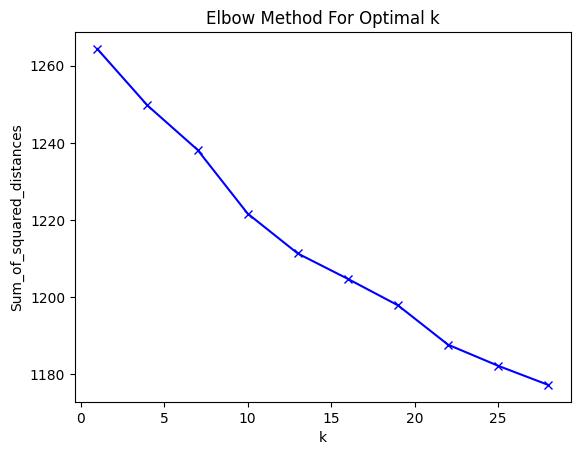

In [89]:
# Elbow method for skills
elbow_method(X_skills, range(1,30,3)) 

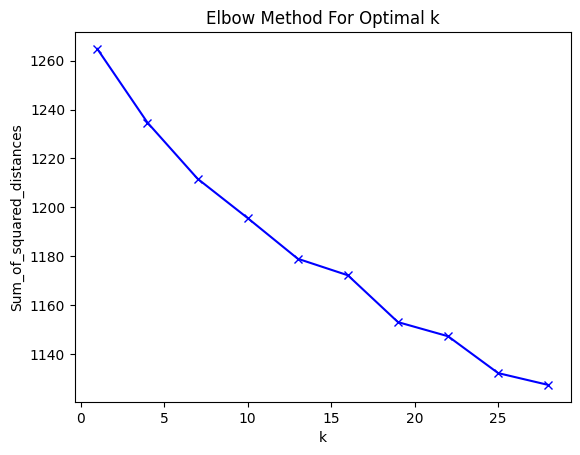

In [95]:
# Elbow method for description
elbow_method(X_description, range(1,30,3))

* It seems like hard to see, but 10 for skills column and 13 for description should be sufficient for our purposes. And with larges number it will be hard to make sence of the clusters.

In [96]:
# For skills
true_k = 10
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10, random_state=10)
model.fit(X_skills)
labels=model.labels_
df['skills_cluster'] = labels

In [97]:
# For description
true_k = 13
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10, random_state=10)
model.fit(X_description)
labels=model.labels_
df['description_cluster'] = labels

5. Visualize the clusters using word clouds. 
6. Adjust clustering parameters, if necessary, to improve the visualized output.
* After playing with different number of clusters I have decided to stop on 6.

In [103]:
def plot_wordcloud(column_name, cluster_column_name, true_k):
    stops = (stopwords.words('english'))
    stops.extend(['experience','position','ability', 'data'])   
    # remove stops from df['skills']
    df[column_name] = df[column_name].str.lower()
    df[column_name] = df[column_name].str.replace(r'\b(' + r'|'.join(stops) + r')\b', '', regex=True)


    result={'cluster':df[cluster_column_name],column_name:df[column_name]}
    result=pd.DataFrame(result)

    for k in range(0,true_k):
        s = result[result.cluster == k]
        text = s[column_name].str.cat(sep=' ')
        text = text.lower()
        text = ' '.join([word for word in text.split()])
        wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text)
        print(f'Cluster: {k}')
        print(f'Number of job postings: {len(s)} - {round(len(s)/len(df)*100,2)}%')

        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

Cluster: 0
Number of job postings: 36 - 2.8%


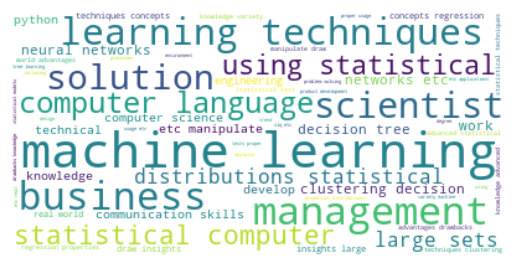

Cluster: 1
Number of job postings: 252 - 19.57%


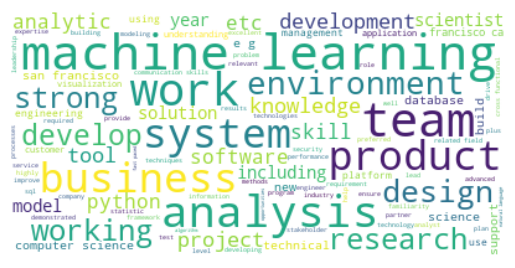

Cluster: 2
Number of job postings: 17 - 1.32%


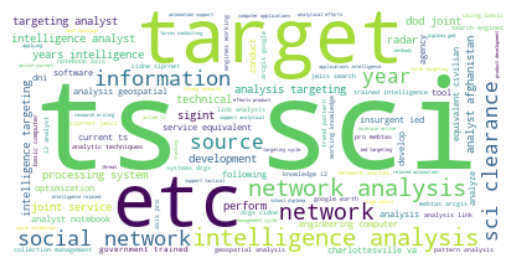

Cluster: 3
Number of job postings: 262 - 20.34%


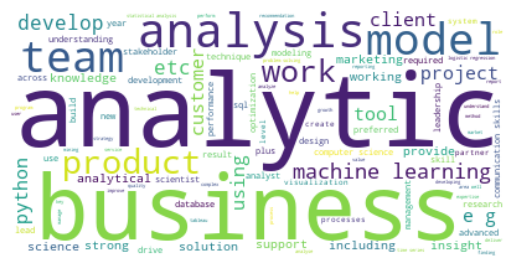

Cluster: 4
Number of job postings: 339 - 26.32%


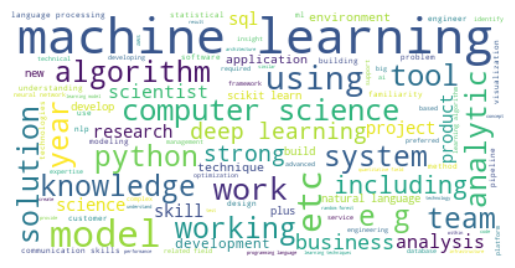

Cluster: 5
Number of job postings: 29 - 2.25%


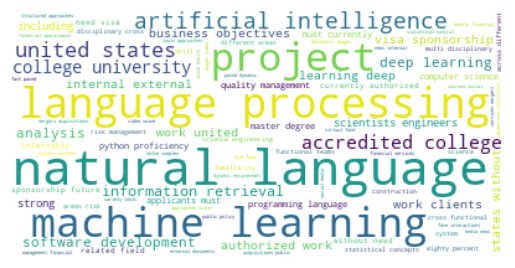

Cluster: 6
Number of job postings: 13 - 1.01%


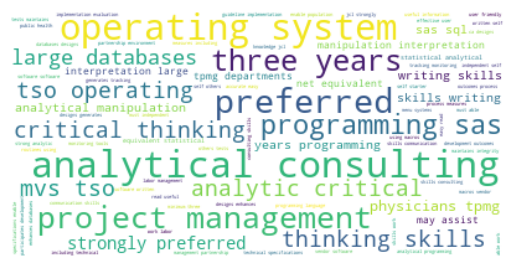

Cluster: 7
Number of job postings: 16 - 1.24%


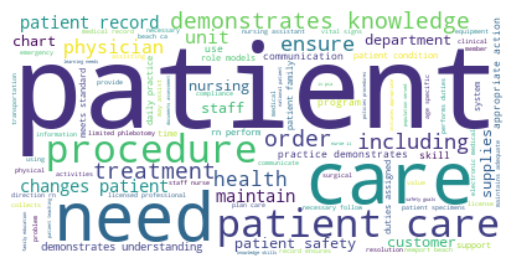

Cluster: 8
Number of job postings: 135 - 10.48%


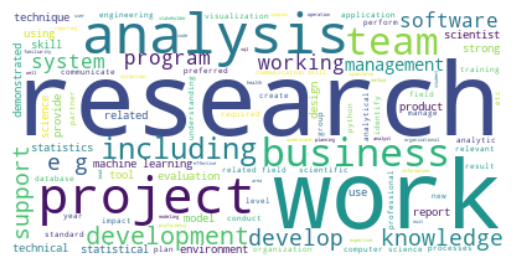

Cluster: 9
Number of job postings: 189 - 14.67%


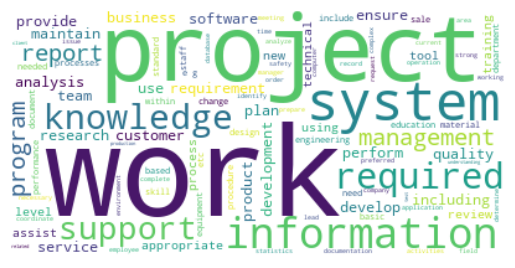

In [104]:
plot_wordcloud(column_name='skills', cluster_column_name='skills_cluster', true_k=10)

* Looking at the clusters BASED ON SKILLS, I think we can make some sense of them.   
Claster 0,1,4,5 - Those resemble out Data Science \ Machine Learning class the most. 53% of the corpus.  
Cluster 2 - seems like network analysis or somethign hard to distinguish.  1% of the corpus.  
Cluster 3 - seems like Business analytics and business in general.  20% of the corpus.  
Cluster 6,9 - seems like consulting, project management etc. 1%+14% = 15% of the corpus.  

Cluster: 0
Number of job postings: 616 - 47.83%


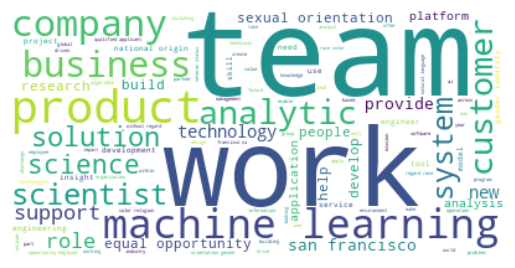

Cluster: 1
Number of job postings: 259 - 20.11%


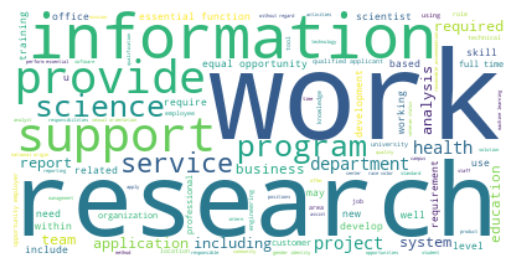

Cluster: 2
Number of job postings: 38 - 2.95%


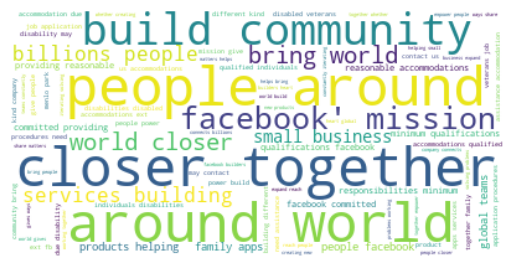

Cluster: 3
Number of job postings: 12 - 0.93%


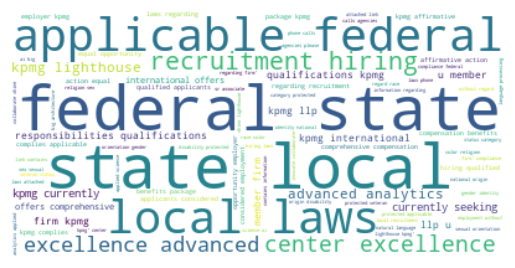

Cluster: 4
Number of job postings: 134 - 10.4%


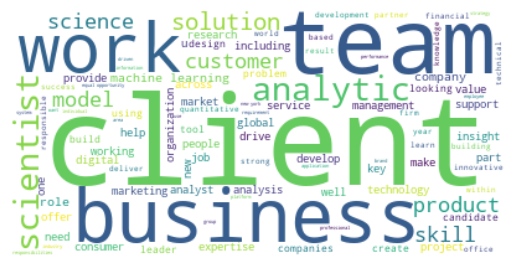

Cluster: 5
Number of job postings: 17 - 1.32%


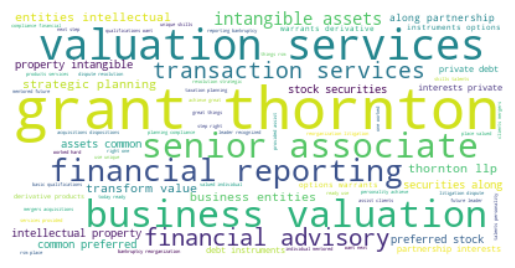

Cluster: 6
Number of job postings: 19 - 1.48%


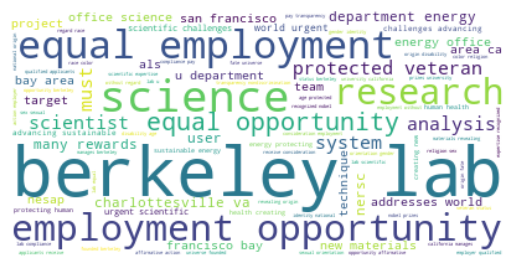

Cluster: 7
Number of job postings: 25 - 1.94%


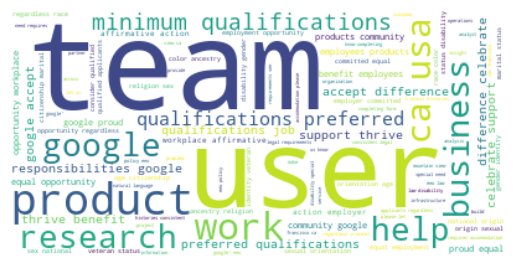

Cluster: 8
Number of job postings: 20 - 1.55%


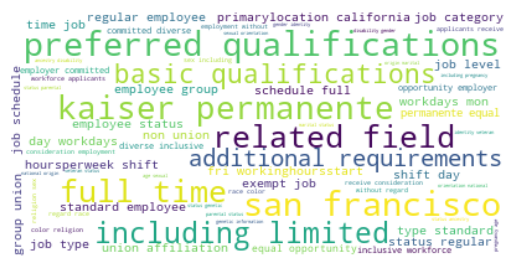

Cluster: 9
Number of job postings: 76 - 5.9%


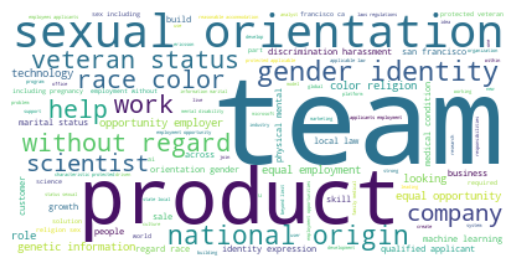

Cluster: 10
Number of job postings: 22 - 1.71%


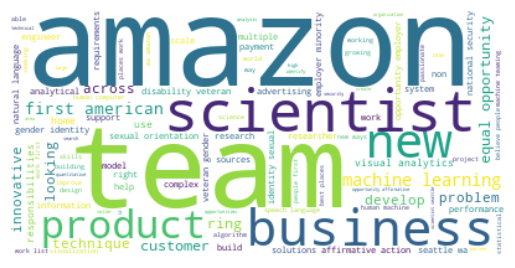

Cluster: 11
Number of job postings: 15 - 1.16%


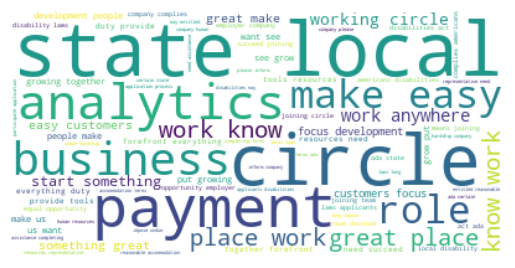

Cluster: 12
Number of job postings: 35 - 2.72%


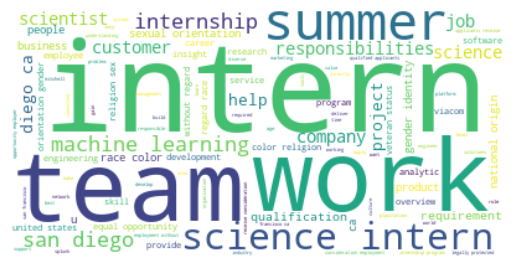

In [106]:
plot_wordcloud('description', 'description_cluster',  13)

* As we can see it is much harder to make sence of the clusters based on description. And most of the clusters are not really meaningful. I will not bu using description for further analysis.

In [107]:
# Filtering jobs based on skills cluster
df_filtered_jobs = df[df['skills_cluster'].isin([0,1,4,5])]
df_filtered_jobs.reset_index(drop=True, inplace=True)
df_filtered_jobs.shape

(656, 5)

* now we have a subset of the resumes I can compare to our resume. However, I would like to run LDA algorithm to see if we can get more meaningful clusters.

##### LDA - Latent Dirichlet Allocation

In [215]:
lda = LatentDirichletAllocation(n_components=14, learning_method='batch', max_iter=25, random_state=11)
X_topics = lda.fit_transform(X_skills)

ValueError: setting an array element with a sequence.

In [162]:
lda.components_.shape

(10, 40348)

* Looking into most importan words for each topic.

In [163]:
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names = np.array(feature_names_skills)

df_topics = pd.DataFrame(columns=['topic', 'words', 'weights'])
for x in range(sorting.shape[0]):
    # append to df_topics
    df_topics = pd.concat( [df_topics , pd.DataFrame({'topic': x, 
                                        'words': [feature_names[i] for i in sorting[x, :7]], 
                                        'weights': [lda.components_[x][i] for i in sorting[x, :7]]}) 
                            ]
                                        )

In [164]:
df_topics.to_csv('df_topics.csv', index=False)

In [214]:
df_topics

topic            words   weights
0      0          privacy  2.236429
1      0           entity  1.110752
2      0               rn  1.097348
3      0         portland  0.999976
4      0            fedex  0.932178
..   ...              ...       ...
2      9          modeler  0.790451
3      9  analyst chicago  0.637994
4      9   virtualization  0.624481
5      9   analyst united  0.606298
6      9           splunk  0.594132

[70 rows x 3 columns]

In [167]:
for x in range(sorting.shape[0]):
    print(f'Topic {x}:')
    print([feature_names_skills[i] for i in sorting[x, :7]])

Topic 0:
['privacy', 'entity', 'rn', 'portland', 'fedex', 'fedex office', 'math statistics']
Topic 1:
['berkeley', 'research data', 'berkeley can', 'data analyst', 'analyst', 'baltimore md', 'baltimore']
Topic 2:
['scientist bellevue', 'bellevue wa', 'bellevue', 'skill distribution', 'good apply', 'wa', 'verifying integrity']
Topic 3:
['consulting', 'analytical consulting', 'sponsor', 'walmart', 'partnership environment', 'labor management', 'management partnership']
Topic 4:
['valuation', 'college university', 'financial datum', 'business valuation', 'lingual', 'accredited college', 'valuation service']
Topic 5:
['dental vision', 'medical dental', 'manufacturing', 'week', 'veteran', 'free', 'root']
Topic 6:
['client', 'datum science', 'ml', 'prefer', 'analyst', 'algorithm', 'financial']
Topic 7:
['counter', 'ie', 'al', 'ts sci', 'hockey', 'ts', 'sci clearance']
Topic 8:
['valuation', 'course work', 'project course', 'robotic', 'scientist remote', 'equity', 'intern data']
Topic 9:
['re

7. Compare the clustered skills to our resume(*) to uncover missing skills.

In [197]:
resume_similarities = cosine_similarity(X_skills)

In [206]:
# find 10 highest similarity job postings for our ( last row ) resume
indexes = resume_similarities[-1].argsort()[-11:]

In [207]:
# getting resumes from main df
most_similar_resumes_df = df.iloc[indexes]

In [208]:
most_similar_resumes_df[['title','skills','skills_cluster','description_cluster']]

title  \
fc4bef82f5ea2f9a.html                                         Data Scientist (PhD) - Intern - Spring, TX   
2efe40d815e4bd1f.html                                                   Data Scientist - Los Angeles, CA   
5745401425aa1cff.html      Associate Director for Strategic Projects in the Dean's Office - New York, NY   
e15d058a38bc2073.html  CIMD - Marcus by Goldman Sachs - Decision and Data Scientist - New York, NY 10282   
b8fdad9355ae03f4.html                                      Sr. Data Scientist(NLP) - Palo Alto, CA 94304   
82afa910a2577a6e.html                                                    Data Scientist - Portsmouth, NH   
4a550147c9332b73.html                                                     Data Scientist - United States   
67fc9b52946a25ed.html                                  Natural Language Processing Expert - San Jose, CA   
570bfe5aaa881f83.html                                     Principal Data Scientist - Ann Arbor, MI 48104   
7ba056b7c3fbf8e7.html                                                Data Scientist - New York, NY 10011   
resume.txt                                                                                     My Resume   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    skills  \
fc4bef82f5ea2f9a.html   scientist (phd) - intern - spring, tx use  visualization, statistical analysis, pattern recognition,  machine learning – along  domain knowledge  subject-specific models –  solve science, engineering,  commercial problems.  extraction/transformation/loading,  filtering  quality control, exploratory  analysis, feature engineering  visualization.   work   structured  unstructured . analyze results  develop technical reports  presentations. currently pursuing  ph..  one   following disciplines...   
2efe40d815e4bd1f.html   scientist - los angeles, ca master' degree  computer science, mathematics, statistics, engineering,   computational/quantitative field  highly desired. phd  preferred. 2   years  advanced  analysis   expertise  diverse statistical,  mining techniques  technologies including: neural networks, deep learning, naive bayes, regression, random forest, clustering, text mining, social network analysis; natural language processing (nlp); supervised  unsupervised machine learning; model validation, t...   
5745401425aa1cff.html  associate director  strategic projects   dean' office - new york, ny requisition : 503640. work type: full time. location: morningside. school/department: columbia business school. grade: grade 13. categories: general administration. job type: officer  administration. bargaining unit:. regular/temporary: regular. end date  temporary:. hours per week: 35. salary range: commensurate  . assist  senior vice dean (svd)   broad range  projects  initiatives, coordinating   senior leaders  admission...   
e15d058a38bc2073.html  cimd - marcus  goldman sachs - decision   scientist - new york, ny 10282 rapidly prototype early-stage solutions  design / evaluate predictive models  advanced algorithms  drive business decisions throughout  customer lifecycle (prospecting, acquisition, underwriting, fraud, collections, enhancing customer ). understand  systems   business processes  populate  systems  . carry   processing including statistical analysis, variable selection,  dimensionality reduction, custom attribute enginee...   
b8fdad9355ae03f4.html  sr.  scientist(nlp) - palo alto, ca 94304 ms (phd preferred)  stem field. 5+ years    building/deploying ml algorithms  working  nlp. solid understan

* In above table we can see 2 things : 
1. Clusters based on description doesn't make sence. so, decision to drop description column was a good one.
2. we have 1 job posting, which belongs to cluster, which doesn't resemple what we are looking for. After review I will drop that record , which belongs to cluster 9.


In [209]:
most_similar_resumes_df = most_similar_resumes_df[most_similar_resumes_df['skills_cluster'] != 9]
most_similar_resumes_df.shape

(10, 5)

* Now we have 9 resumes + 1 our, we can use as a guidline for learning new skills. Let's see what skills we are missing.

In [210]:
most_similar_resumes_df['skills'].iloc[0]

' scientist (phd) - intern - spring, tx use  visualization, statistical analysis, pattern recognition,  machine learning – along  domain knowledge  subject-specific models –  solve science, engineering,  commercial problems.  extraction/transformation/loading,  filtering  quality control, exploratory  analysis, feature engineering  visualization.   work   structured  unstructured . analyze results  develop technical reports  presentations. currently pursuing  ph..  one   following disciplines: engineering/sciences, mathematics, statistics  computer science  significant    analytics.   python, scala, java, c, c++  r  required.  following experiences   considered  advantage,   required:\nusing one     following software packages: scikit-learn, numpy, pandas, jupyter, matplotlib, scipy, nltk, spacy, keras, tensorflowsolving problems using techniques including regression, support vector machines, decision trees, random forest, boosting, pca, kmeansusing sql/ sql databases   advantageworkin